# Load data (dataframe consisted of state vectors over time)

In [1]:
import utils as utils
import pandas as pd
import pysindy as ps
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from pysindy.utils.odes import lorenz

dataUniqueSatellite, allFilesOrbitalUnpickled, realEpochSinceUniqueSatellite = utils.loadData()


In [7]:
print(dataUniqueSatellite.head())

             posX          posY          posZ         velX         velY  \
2   -9.062010e+05 -1.806163e+06  6.660926e+06 -6096.305025 -4051.004475   
248  2.813836e+06  9.946230e+05  6.293880e+06 -5280.836357 -4475.702760   
494  5.191148e+06  3.461686e+06  3.121400e+06 -2141.312061 -2842.415298   
740  5.203141e+06  4.434655e+06 -1.442530e+06  1861.210082   174.774773   
986  2.912542e+06  3.404751e+06 -5.367801e+06  4916.844817  3225.602653   

            velZ  
2   -1929.165161  
248  3051.648117  
494  6669.392789  
740  7314.738571  
986  4717.562016  


# Using ODEINT to generate artificial data (propagating the initial states of the satellites using the PDEs)

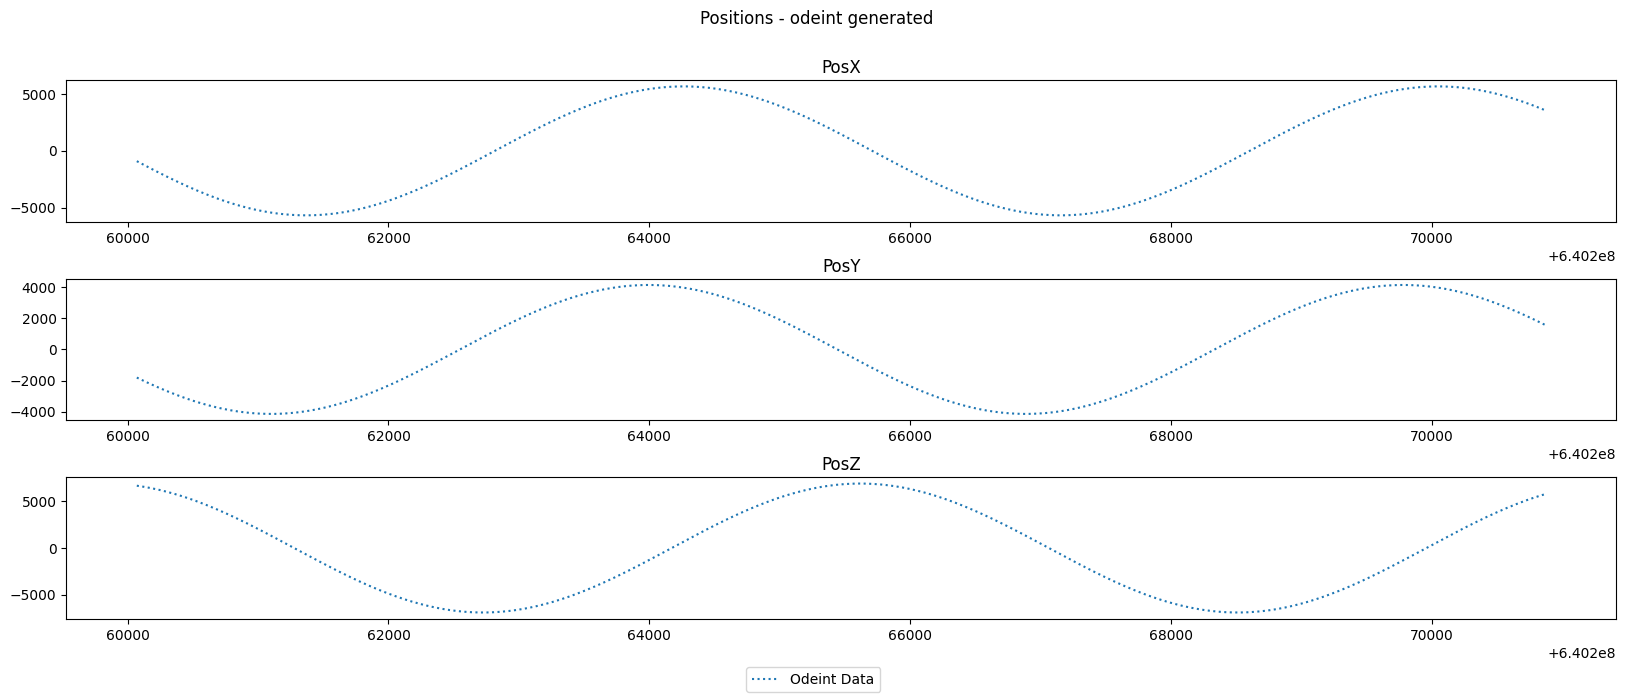

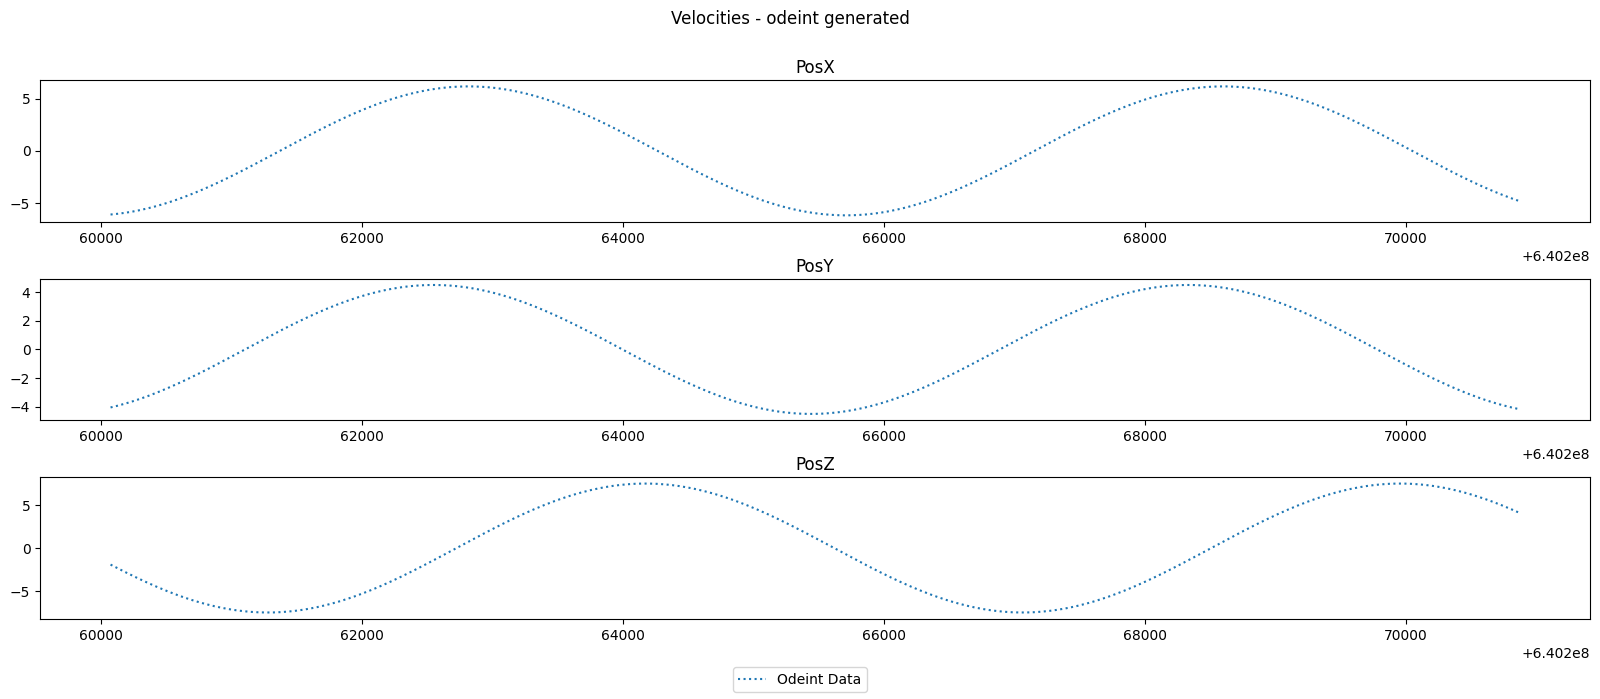

In [3]:
from scipy.integrate import odeint
import utils as utils
import plot as plot
import numpy as np

initialData = dataUniqueSatellite.iloc[0].to_list()
#TEMPO DE 10 EM 10 SEGUNDOS DURANTE 3 HORAS
time = realEpochSinceUniqueSatellite.copy().tolist()[0] + np.linspace(0, 10800, 573)

sol1stDerivative = utils.applyOdeint(initialData, time, derivative = "first")
#divide all collumns by 1000 to get km
sol1stDerivativeKm = sol1stDerivative.copy()/1000

plot.plotPositionsVelocities(time, sol1stDerivativeKm)

# SINDY with ODEINT data - First derivative

In [ ]:
############## Functions ################      

###### 1st Derivative (clean) ######
library_functions1stDeriv = [lambda x: x,
                                lambda a, b, c : a/(a**2 + b**2 + c**2)**(3/2),
                                lambda a, b, c : b/(a**2 + b**2 + c**2)**(3/2),
                                lambda a, b, c : c/(a**2 + b**2 + c**2)**(3/2)]

library_function_names1stDeriv = [lambda x: "*" + x, 
                                    lambda a, b, c: "*" + a + "/((" + a + "**2 + " + b + "**2 + " + c + "**2)**(3/2))",
                                    lambda a, b, c: "*" + b + "/((" + a + "**2 + " + b + "**2 + " + c + "**2)**(3/2))",
                                    lambda a, b, c: "*" + c + "/((" + a + "**2 + " + b + "**2 + " + c + "**2)**(3/2))"]

pde_lib1stDeriv = ps.WeakPDELibrary(
    library_functions=library_functions1stDeriv,
    function_names=library_function_names1stDeriv,
    spatiotemporal_grid=time,
    derivative_order=1,
    is_uniform=True,
    K=500
)

###### 2nd Derivative (clean) ######

library_functions2ndDeriv = [lambda a, b, c :  a/(a**2 + b**2 + c**2)**(3/2),
                                lambda a, b, c :  b/(a**2 + b**2 + c**2)**(3/2),
                                lambda a, b, c : c/(a**2 + b**2 + c**2)**(3/2)]

library_function_names2ndDeriv = [lambda a, b, c: "*" + a + "/((" + a + "**2 + " + b + "**2 + " + c + "**2)**(3/2))",
                                    lambda a, b, c: "*" + b + "/((" + a + "**2 + " + b + "**2 + " + c + "**2)**(3/2))",
                                    lambda a, b, c: "*" + c + "/((" + a + "**2 + " + b + "**2 + " + c + "**2)**(3/2))"]
                    

pde_lib2ndDeriv = ps.WeakPDELibrary(
    library_functions=library_functions2ndDeriv,
    function_names=library_function_names2ndDeriv,
    spatiotemporal_grid=time,
    derivative_order=1,
    is_uniform=True,
    K=1000
)

########## drag ###########
library_functionsDrag = [lambda x: x,
                    lambda a, b, c : a/((a**2 + b**2 + c**2)**(3/2)),
                    lambda a, b, c : b/((a**2 + b**2 + c**2)**(3/2)),
                    lambda a, b, c : c/((a**2 + b**2 + c**2)**(3/2)),
                    
                    
                    lambda a, b, c: ((a**2 + b**2 + c**2)**(1/2)) * a,
                    lambda a, b, c: ((a**2 + b**2 + c**2)**(1/2)) * b,
                    lambda a, b, c: ((a**2 + b**2 + c**2)**(1/2)) * c]

library_function_namesDrag = [lambda x: "*" + x, 
                          lambda a, b, c: "*" + a + "/((" + a + "**2 + " + b + "**2 + " + c + "**2)**(3/2))",
                          lambda a, b, c: "*" + b + "/((" + a + "**2 + " + b + "**2 + " + c + "**2)**(3/2))",
                          lambda a, b, c: "*" + c + "/((" + a + "**2 + " + b + "**2 + " + c + "**2)**(3/2))",

                            lambda a, b, c: "*(" + a + "**2 + " + b + "**2 + " + c + "**2)**(1/2) * " + a,
                            lambda a, b, c: "*(" + a + "**2 + " + b + "**2 + " + c + "**2)**(1/2) * " + b,
                            lambda a, b, c: "*(" + a + "**2 + " + b + "**2 + " + c + "**2)**(1/2) * " + c
                        ]


pde_libDrag = ps.WeakPDELibrary(
    library_functions=library_functionsDrag,
    function_names=library_function_namesDrag,
    spatiotemporal_grid=time,
    derivative_order=1,
    is_uniform=True,
    K=1000
)


#Different types of optimizers
#Check documentation for more details @ https://pysindy.readthedocs.io/en/latest/api/pysindy.optimizers.html


optimizer4 = ps.FROLS(alpha=1e-9, kappa=1e-33)
optimizer = ps.FROLS()
optimizer1 = ps.STLSQ(threshold=.1, alpha=0.0005)
optimizer2 = ps.SSR(alpha=.05)
optimizer3 = ps.SSR(alpha=.1, criteria="model_residual", kappa=1e-2) 
optimizer5 = ps.SSR(alpha=.3, criteria="model_residual", kappa=1e-4) #k determina quao esparsa é a solucao
# optimizer4 = ps.FROLS(alpha=.000000001, kappa=0.00000000000000000000000000000000000000000000000000001)
optimizer7 = ps.STLSQ(threshold=0.9, alpha=1e-10)
optimizer6 = ps.SSR(alpha=.001, normalize_columns=True)

In [ ]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

polynomialLib = ps.PolynomialLibrary(degree=4)

###########
#kilometers
###########

####### CALCULAR XDOT NAO STANDARDIZADO #######

x_dotCalculated = utils.calculateXdot(sol1stDerivativeKm)

##############################################

                                                                            #################
                                                                            # nao normalizado
                                                                            #################

# using the non normalized data, we are able to find the earth's standard gravitational parameter

optimizerKms = ps.FROLS(alpha=1e-31)
# , feature_library=pde_lib1stDeriv
model1stNotStandardized = ps.SINDy(feature_names=["posX", "posY", "posZ", "velX", "velY", "velZ"], optimizer= optimizerKms, feature_library=pde_lib1stDeriv)
# # , x_dot = np.array(x_dotCalculated)
model1stNotStandardized.fit(sol1stDerivativeKm, t=time, ensemble=True, quiet=True)
# model1stNotStandardized.fit(dataDense, t=timeDense, ensemble=True, quiet=True)

model1stNotStandardized.print()
# data1stSimulatedNotStandardized = model1stNotStandardized.simulate(x0=sol1stDerivativeKm[0], t=time, integrator='odeint')
data1stSimulated = utils.useSindyEquations(model1stNotStandardized, sol1stDerivativeKm[0], time, "kilometers")
# deStandardizedData = scalerData.inverse_transform(data1stSimulated)

                                                                            ###################
                                                                            #normalizado
                                                                            ###################

# # Normalize data
# #axis = 0 => normaliza por coluna
# normalizedOdeintData = preprocessing.normalize(sol1stDerivativeKm, axis=0)
# normalizedOdeintData = pd.DataFrame(normalizedOdeintData, columns=["posX", "posY", "posZ", "velX", "velY", "velZ"])
# normalizedXdotCalculated = preprocessing.normalize(x_dotCalculated, axis=0)
# normalizedXdotCalculated = pd.DataFrame(normalizedXdotCalculated, columns=["velX", "velY", "velZ", "accX", "accY", "accZ"])

# optimizerKms = ps.FROLS()
# # x_dot=np.array(normalizedXdotCalculated))
# model1stNormalized = ps.SINDy(feature_names=["posX", "posY", "posZ", "velX", "velY", "velZ"], optimizer= optimizerKms, feature_library=polynomialLib)
# model1stNormalized.fit(normalizedOdeintData, t=time, ensemble=True, quiet=True)
# model1stNormalized.print()
# data1stSimulatedNormalized = model1stNormalized.simulate(x0=normalizedOdeintData.iloc[0].to_numpy(), t=time, integrator='odeint')
# # data1stSimulated = tu.useSindyEquations(model1stNormalized,normalizedOdeintData.iloc[0].to_numpy(), time, "kilometers")

                                                                            ###################
                                                                            # standardized
                                                                            ###################

# standardizedXdotScaler1st = StandardScaler()
# standardizedXdot1st = standardizedXdotScaler1st.fit_transform(np.array(x_dotCalculated))

# optimizerKms = ps.FROLS(verbose=False)
# # optimizerKms = ps.FROLS(alpha=1e-3)
# scalerData = StandardScaler()
# scaledOdeintData = scalerData.fit_transform(sol1stDerivativeKm)
# scalerTime = StandardScaler()
# scaledTime = scalerTime.fit_transform(time.reshape(-1,1)).flatten()
# model1stStandardized = ps.SINDy(feature_names=["posX", "posY", "posZ", "velX", "velY", "velZ"], optimizer= optimizerKms, feature_library=pde_lib1stDeriv)
# #  ,x_dot = standardizedXdot1st
# model1stStandardized.fit(scaledOdeintData, t=scaledTime, ensemble=True, quiet=True)
# model1stStandardized.print()

# #de-standardize
# print(scaledOdeintData[0].shape)
# print(scaledTime.shape)
# # data1stSimulatedScaled = model1stStandardized.simulate(x0=scaledOdeintData[0], t=scaledTime, integrator='odeint')
# data1stSimulated = utils.useSindyEquations(model1stStandardized,scaledOdeintData[0], scaledTime, "kilometers")
# deStandardizedData = scalerData.inverse_transform(data1stSimulated)


(posX)' = 1.000 *velX + 0.008 *velY/((posZ**2 + velY**2 + velZ**2)**(3/2))
(posY)' = 1.000 *velY
(posZ)' = 1.000 *velZ + 2406.296 *velX/((posY**2 + posZ**2 + velX**2)**(3/2)) + 0.002 *velZ/((velX**2 + velY**2 + velZ**2)**(3/2))
(velX)' = -398600.442 *posX/((posX**2 + posY**2 + posZ**2)**(3/2)) + -1.379 *velX/((posY**2 + posZ**2 + velX**2)**(3/2))
(velY)' = -398600.441 *posY/((posX**2 + posY**2 + posZ**2)**(3/2))
(velZ)' = -398600.441 *posZ/((posX**2 + posY**2 + posZ**2)**(3/2)) + -1.476 *velZ/((posY**2 + posZ**2 + velZ**2)**(3/2))
(posX)' = 1.000 *velX + 0.008 *velY/((posZ**2 + velY**2 + velZ**2)**(3/2))
(posY)' = 1.000 *velY
(posZ)' = 1.000 *velZ + 2406.296 *velX/((posY**2 + posZ**2 + velX**2)**(3/2)) + 0.002 *velZ/((velX**2 + velY**2 + velZ**2)**(3/2))
(velX)' = -398600.442 *posX/((posX**2 + posY**2 + posZ**2)**(3/2)) + -1.379 *velX/((posY**2 + posZ**2 + velX**2)**(3/2))
(velY)' = -398600.441 *posY/((posX**2 + posY**2 + posZ**2)**(3/2))
(velZ)' = -398600.441 *posZ/((posX**2 + posY**2

In [ ]:
############ PLOTS ##############
plot.plot_orbits_versus(time, sol1stDerivativeKm, data1stSimulated)
# plot.plot_orbits_versus(scaledTime, sol1stDerivativeKm, deStandardizedData)

# MULTIPLE TRAJECTORIES - Primeira Derivada

In [ ]:
                                                            #######################################################################
                                                            ### Preparare the data
                                                            #######################################################################

listOrbitsStatesOdeint, listOrbitsDerivs, listOrbitTimesOdeint = utils.prepare_data_multiple_orbits()


                                                            #######################################################################
                                                            # PRIMEIRA DERIVADA
                                                            #######################################################################


################
#nao normalizado (com e sem x_dot)
################

# optimizerTest = ps.STLSQ(alpha=1e-30, threshold= 1e-35)
# optimizerTest = ps.FROLS()
# model1stMultipleNotStandardized = ps.SINDy(feature_names=["posX", "posY", "posZ", "velX", "velY", "velZ"], optimizer=optimizerTest)
# # x_dot = listOrbitsDerivs
# model1stMultipleNotStandardized.fit(listOrbitsStatesOdeint, t=listOrbitTimesOdeint, multiple_trajectories=True, quiet = True, x_dot = listOrbitsDerivs)
# model1stMultipleNotStandardized.print()
# #simulate for one orbit
# simulated1stMultipleNotStandardized = model1stMultipleNotStandardized.simulate(listOrbitsStatesOdeint[2][0], t=listOrbitTimesOdeint[2], integrator="odeint")


################
# normalizado
################


# listOrbitsStatesOdeintNormalized = []
# for orbit in listOrbitsStatesOdeint:
#     normalizedOdeintDataAux = preprocessing.normalize(orbit, axis=0)
#     normalizedOdeintDataAux = pd.DataFrame(normalizedOdeintDataAux, columns=["posX", "posY", "posZ", "velX", "velY", "velZ"])
#     listOrbitsStatesOdeintNormalized.append(normalizedOdeintDataAux.to_numpy())

# listOrbitsDerivsNormalized = []
# for orbit in listOrbitsDerivs:
#     normalizedDerivsAux = preprocessing.normalize(orbit, axis=0)
#     normalizedDerivsAux = pd.DataFrame(normalizedDerivsAux, columns=["posX", "posY", "posZ", "velX", "velY", "velZ"])
#     listOrbitsDerivsNormalized.append(normalizedDerivsAux.to_numpy())


# optimizerTestNormalized = ps.FROLS(alpha=1e-3)
# modelMultipleNormalized = ps.SINDy(feature_names=["posX", "posY", "posZ", "velX", "velY", "velZ"], optimizer=optimizerTestNormalized, feature_library = ps.PolynomialLibrary(degree=2))
# # , x_dot = listOrbitsDerivsNormalized
# modelMultipleNormalized.fit(listOrbitsStatesOdeintNormalized, t=listOrbitTimesOdeint, multiple_trajectories=True, quiet = True)
# modelMultipleNormalized.print()
# sindy_statesNormalized = modelMultipleNormalized.simulate(listOrbitsStatesOdeintNormalized[0][0], t=listOrbitTimesOdeint[0], integrator="odeint")


################
# standardizado
################

listOrbitsDerivsStandardized, listOrbitsStatesOdeintStandardized, listScalersDerivs, listScalersData, listOrbitsTimesOdeintStandardized, listScalersTime = utils.standardizeInputs(listOrbitsDerivs, listOrbitsStatesOdeint, listOrbitTimesOdeint)

optimizerTestStandardized = ps.FROLS(alpha = 1e-6)
# optimizerTestStandardized = ps.FROLS()
model1stMultipleStandardized = ps.SINDy(feature_names=["posX", "posY", "posZ", "velX", "velY", "velZ"], optimizer=optimizerTestStandardized, feature_library = ps.PolynomialLibrary(degree=4))
# # , x_dot = listOrbitsDerivsStandardized
model1stMultipleStandardized.fit(listOrbitsStatesOdeintStandardized, t=listOrbitsTimesOdeintStandardized, multiple_trajectories=True, quiet = True)
model1stMultipleStandardized.print()

sindy_stateStandardized = model1stMultipleStandardized.simulate(listOrbitsStatesOdeintStandardized[2][0], t=listOrbitsTimesOdeintStandardized[2], integrator="odeint")
descaledOrbitStates = listScalersData[2].inverse_transform(sindy_stateStandardized)


In [ ]:
plot.plot_orbits_versus(listOrbitsTimesOdeintStandardized[2], listOrbitsStatesOdeint[2], descaledOrbitStates, title="SINDy orbit")
# plot_orbits_versus(listOrbitsTimesOdeintStandardized[2], listOrbitsStatesOdeintStandardized[2], sindy_stateStandardized, title="SINDy orbit")


# SINDY DADOS ODEINT - SEGUNDA DERIVADA

In [ ]:
                                                                                # ####################
                                                                                # # segunda derivada #
                                                                                # ####################

x_dotCalculated = utils.calculateXdot(sol1stDerivativeKm)
x_dotCalculated2nd = utils.calculate2ndXdot(x_dotCalculated)


                                                    ##################
                                                    # Nao normalizado
                                                    ##################


# # calcular a primeira derivada dos resultados da primeira derivada das posivoes
# optimizerTest = ps.STLSQ(threshold=1e-15, alpha=1e-15)
# # optimizerTest = ps.SSR()
# model2ndNotStandardized = ps.SINDy(feature_names=["posX", "posY", "posZ"], optimizer= optimizerTest, feature_library=ps.PolynomialLibrary(degree=4))
# # #, x_dot = np.array(x_dotCalculated2nd)
# model2ndNotStandardized.fit(np.array(x_dotCalculated1st), t=time, ensemble=True, quiet = True, x_dot = np.array(x_dotCalculated2nd))
# model2ndNotStandardized.print()
# simulated2ndNotStandardized = model2ndNotStandardized.simulate(x_dotCalculated1st[0], t=time, integrator = 'odeint')
# # simulated2ndNotStandardized = tu.applyOdeint2ndDerivative(model4th, x_dotCalculated[0], time, "kilometers")
# # #.print(lhs=['(posX)\'\'', '(posY)\'\'', '(posZ)\'\''])

                                                    ###############
                                                    # normalizado
                                                    ###############

# normalizedXdotCalculated = np.array(normalizedXdotCalculated)[:,0:3]
# normalizedXdotCalculated2nd = []
# for x in normalizedXdotCalculated: 
#     normalizedXdotCalculated2nd.append(np.array(functionToIntegrate2nd(x, 0, "kilometers")))

# normalizedXdotCalculated = np.array(normalizedXdotCalculated)[:,0:3]
# optimizerTest = ps.SSR()
# # optimizerTest = ps.STLSQ(threshold = 1e-4)
# model5th = ps.SINDy(feature_names=["posX", "posY", "posZ"], optimizer= optimizerTest)
# model5th.fit(np.array(normalizedXdotCalculated), t=time, ensemble=True, quiet = True)
# model5th.print()
# dataModel5thSimulated = model5th.simulate(normalizedXdotCalculated[0], t=time, integrator = 'odeint')
# # dataModel5thSimulated = tu.applyOdeint2ndDerivative(model5th, normalizedXdotCalculated[0], time, "kilometers")
# print("Simulated second derivative without xdot - normalized")

                                                    ###############
                                                    # standardized
                                                    ###############

#standardize the xdot
standardizedXdotScaler = StandardScaler()
xDotPositions = np.array(x_dotCalculated)[:,0:3]
standardizedXdot = standardizedXdotScaler.fit_transform(xDotPositions)

def functionToIntegrate2nd(valuesList, time, units = "meters"):
        posX = valuesList[0]
        posY = valuesList[1]
        posZ = valuesList[2]
        if units == "meters":
            standardGravitationalParameter = 3.986004418 * 10**(14)
        else:
            standardGravitationalParameter = 3.986004418 * 10**(5)


        return [-standardGravitationalParameter * posX/(posX**2 + posY**2 + posZ**2)**(3/2), 
                -standardGravitationalParameter * posY/(posX**2 + posY**2 + posZ**2)**(3/2), 
                -standardGravitationalParameter * posZ/(posX**2 + posY**2 + posZ**2)**(3/2)]
#calculate the second derivative of the standardized xdot
standardizedXdotCalculated2nd = []
for x in standardizedXdot: 
    standardizedXdotCalculated2nd.append(np.array(functionToIntegrate2nd(x, 0, "kilometers")))


# optimizerTest = ps.STLSQ(alpha = 1e-30, threshold = 1e-21)
optimizerTest = ps.FROLS(alpha = 1e-100)
# optimizerTest = ps.STLSQ(threshold = 1e-30, alpha = 1e-10)
model2ndStandardized = ps.SINDy(feature_names=["velX", "velY", "velZ"], optimizer= optimizerTest)
# # , x_dot = np.array(standardizedXdotCalculated2nd) sem x_dot da sempre um traço
model2ndStandardized.fit(standardizedXdot, t=time, ensemble=True, quiet = True)
model2ndStandardized.print()
dataModel2ndSimulatedStandardized = model2ndStandardized.simulate(standardizedXdot[0], t=time, integrator = 'odeint')
# dataModel5thSimulated = tu.applyOdeint2ndDerivative(model5th, normalizedXdotCalculated[0], time, "kilometers")
dataModel2ndSimulated = standardizedXdotScaler.inverse_transform(dataModel2ndSimulatedStandardized)


In [ ]:
import plot as plot

# integrate the velocity matrix to get position matrix

positionMatrix = utils.integrateVelocityMatrix(time, sol1stDerivativeKm, dataModel2ndSimulated)

## PLOT ##
plot.plot_positionIntegrated_VS_positions(positionMatrix, sol1stDerivativeKm, time)

# MULTIPLE TRAJECTORIES - Segunda Derivada

In [ ]:

#                                                         #######################################################################
#                                                         ######### segunda derivada 
#                                                         #######################################################################

# ###########################################
# #nao normalizado (com e sem x_dot)
# ###########################################

# firstDerivsToIterate = []
# for i in listOrbitsDerivs:
#     firstDerivsToIterate.append(i.copy()[:,0:3])

# listOrbitsSecondDerivs = []
# for orbit in firstDerivsToIterate:
#     listSecDerivsSingleOrbit = []
#     for state in orbit:
#         listSecDerivsSingleOrbit.append(np.array(functionToIntegrate2nd(state, 0, "kilometers")))
#     listOrbitsSecondDerivs.append(np.array(listSecDerivsSingleOrbit))

# optimizerTestSecond = ps.FROLS()
# # optimizerTestSecond = ps.STLSQ(alpha = 1e-10, threshold = 1e-4)
# modelMultipleSecond = ps.SINDy(feature_names=["velX", "velY", "velZ"], optimizer=optimizerTestSecond, feature_library = polynomialLib)
# # # x_dot = listOrbitsSecondDerivs,
# modelMultipleSecond.fit(firstDerivsToIterate, t=listOrbitTimesOdeint, multiple_trajectories=True, quiet = True)
# modelMultipleSecond.print()
# sindy_statesSecond = modelMultipleSecond.simulate(firstDerivsToIterate[2][0], t=listOrbitTimesOdeint[2], integrator="odeint")


# ###########################################
# # Standardizado (com e sem x_dot)
# ###########################################

# selecionar apenas as posicoes
firstDerivsToIterateStandardized = []
for i in listOrbitsDerivsStandardized:
    firstDerivsToIterateStandardized.append(i.copy()[:,0:3])

# calcular as derivadas para o argumento x_dot
listOrbitsSecondDerivsStandardized = []
for orbit in firstDerivsToIterateStandardized:
    listSecDerivsSingleOrbit = []
    for state in orbit:
        listSecDerivsSingleOrbit.append(np.array(functionToIntegrate2nd(state, 0, "kilometers")))
    listOrbitsSecondDerivsStandardized.append(np.array(listSecDerivsSingleOrbit))

#ps.FROLS(alpha = 1e-4)
optimizerTestStandardizedSecond = ps.FROLS(alpha = 1e-75)
modelMultipleStandardizedSecond = ps.SINDy(feature_names=["velX", "velY", "velZ"], optimizer=optimizerTestStandardizedSecond, feature_library = polynomialLib)
# # # x_dot = listOrbitsSecondDerivsNormalized,
modelMultipleStandardizedSecond.fit(firstDerivsToIterateStandardized, t=listOrbitsTimesOdeintStandardized, multiple_trajectories=True, quiet = True)
modelMultipleStandardizedSecond.print()
#32
scalerAuxMultOrbit = StandardScaler()
scaledAuxMultOrbit = scalerAuxMultOrbit.fit_transform(listOrbitsDerivs[2][:,0:3])
sindy_stateStandardizedMult = modelMultipleStandardizedSecond.simulate(scaledAuxMultOrbit[0], t=listOrbitsTimesOdeintStandardized[2], integrator="odeint")
descaledOrbitStatesMult = scalerAuxMultOrbit.inverse_transform(sindy_stateStandardizedMult)


plot.plot_orbit(descaledOrbitStatesMult[:,0], descaledOrbitStatesMult[:,1], descaledOrbitStatesMult[:,2])


positionMatrixMultiple = utils.integrateVelocityMatrix(listOrbitTimesOdeint[2], listOrbitsStatesOdeint[2], descaledOrbitStatesMult)



In [ ]:
plot.plot_orbits_versus(listOrbitsTimesOdeintStandardized[2], listOrbitsStatesOdeint[2], np.array(positionMatrixMultiple), "Integrated Velocities VS Odeint Positions")

# ODEINT - Generate data with drag

In [ ]:
#apply odeint with default drag equations (1st derivative)
#in meters
solDrag = utils.applyOdeint1stDerivDrag(initialData, time)

# first row of sol is the initial state
# first column of sol is the posX
plt.plot(time, solDrag[:,0], label="OdeintDeriv")
plt.figure()
plt.plot(time, np.linalg.norm(solDrag[:,0:3]/1000, axis = 1), 'b', label='posição')
plt.figure()


                                                #######################################################################
                                                ### Preparare the data
                                                #######################################################################


listOrbitsStatesOdeintDrag, listOrbitsWithoutDrag, listOrbitTimesOdeintDrag = utils.prepare_data_drag()


# SINDY with odeint generated data (with drag) - first derivative

In [ ]:

xDotDragOrbits = utils.calculateXdotOrbitsDrag(listOrbitsStatesOdeintDrag)

#meters
#0.00001 detetou posicoes a 1 e o resto a 0
# optimizer4 = ps.FROLS()

# model = ps.SINDy(feature_names=["posX", "posY", "posZ", "velX", "velY", "velZ"], optimizer= optimizer4, 
#         feature_library=pde_libDrag)
# model.fit(solDrag, t=time, ensemble=True, quiet=True)
# model.print()

############################################

##################
# nao standardizado
##################

# #kilometers
# optimizerPdeLibDrag = ps.FROLS(alpha=1e-3) # para pde_libDrag
# optimizerPoly = ps.FROLS(alpha = 1e-20) 
# modelDragKm = ps.SINDy(feature_names=["posX", "posY", "posZ", "velX", "velY", "velZ"], optimizer= optimizerPdeLibDrag, feature_library=pde_libDrag)
# modelDragKm.fit(listOrbitsStatesOdeintDrag[2], t=listOrbitTimesOdeintDrag[2], ensemble=True, quiet=True)
# modelDragKm.print()
# simulateWeak = tu.useSindyEquations(modelDragKm, listOrbitsStatesOdeintDrag[2][0], listOrbitTimesOdeintDrag[2])
# # simulatePoly = modelDragKm.simulate(listOrbitsStatesOdeintDrag[2][0], listOrbitTimesOdeintDrag[2], integrator = "odeint")

# plot.plot_orbit(listOrbitsStatesOdeintDrag[2][:,0], listOrbitsStatesOdeintDrag[2][:,1], listOrbitsStatesOdeintDrag[2][:,2],title="SINDy orbit")
# # plot.plot_orbit(simulatePoly[:,0], simulatePoly[:,1], simulatePoly[:,2],title="SINDy orbit")
# plot.plot_orbit(simulateWeak[:,0], simulateWeak[:,1], simulateWeak[:,2],title="SINDy orbit")

###################
# Standardized
##################

# #standardizeDrag
# scalerDrag = StandardScaler()
# scaledDrag = scalerDrag.fit_transform(listOrbitsStatesOdeintDrag[2])
# scalerXdotDragAux = StandardScaler()
# scaledXdotDragAux = scalerXdotDragAux.fit_transform(xDotDragOrbits[2])


# #FROLS com alpha = -38 e sem kappa deu 1x
# optimizerPoly = ps.FROLS(alpha = 1e-3)
# optimizerPolyXdot = ps.STLSQ(alpha = 1e-50)
# #alpha = 1e-35, kappa = 1e-20
# #alpha = 1e-45, kappa = 1e-20
# optimizerPdeLibDrag = ps.FROLS()
# modelDragKmStandardized = ps.SINDy(feature_names=["posX", "posY", "posZ", "velX", "velY", "velZ"], optimizer= optimizerPoly, feature_library=polynomialLib)
# # # , x_dot = scaledXdotDragAux
# modelDragKmStandardized.fit(scaledDrag, t=listOrbitTimesOdeintDrag[2], ensemble=True, quiet=True)
# modelDragKmStandardized.print()
# simulatedDragStandardized = modelDragKmStandardized.simulate(scaledDrag[0], t=listOrbitTimesOdeintDrag[2], integrator="odeint")
# # simulateDragStandardizedWeak = tu.useSindyEquations(modelDragKmStandardized, scaledDrag[0], listOrbitTimesOdeintDrag[2])

# simulatedDragDestandardized = scalerDrag.inverse_transform(simulatedDragStandardized)
# plot.plot_orbit(listOrbitsStatesOdeintDrag[2][:,0], listOrbitsStatesOdeintDrag[2][:,1], listOrbitsStatesOdeintDrag[2][:,2],title="SINDy orbit")
# plot.plot_orbit(simulatedDragDestandardized[:,0], simulatedDragDestandardized[:,1], simulatedDragDestandardized[:,2],title="SINDy orbit")


###################
# Standardized/nonstandardized with multiple orbits
##################

standardizedXdotDragOrbits, standardizedOrbitsDrag, scalersXdotDrag, scalersDrag, standardizedTimeDragOrbits, scalersTimeDrag = utils.standardizeInputs(xDotDragOrbits, listOrbitsStatesOdeintDrag, listOrbitTimesOdeintDrag)


# optimizerNoXdot = ps.FROLS(alpha = 1e-3)
optimizerNoXdot = ps.FROLS(alpha = 1e-54)
optimizerXdot = ps.STLSQ(alpha = 1e-30,threshold=1e-3)
optimizeNonStandardized = ps.FROLS(alpha = 1e-100)
modelDragKmStandardizedMult = ps.SINDy(feature_names=["posX", "posY", "posZ", "velX", "velY", "velZ"], optimizer= optimizerNoXdot, feature_library=polynomialLib)
# # ,x_dot = standardizedXdotDragOrbits
modelDragKmStandardizedMult.fit(standardizedOrbitsDrag, t=standardizedTimeDragOrbits, ensemble=True, quiet=True, multiple_trajectories=True)
# modelDragKmStandardizedMult.fit(standardizedOrbitsDrag[2], t=listOrbitTimesOdeintDrag[2], ensemble=True, quiet=True)
modelDragKmStandardizedMult.print()

simulatedDragStandardizedMult = modelDragKmStandardizedMult.simulate(standardizedOrbitsDrag[2][0], t=standardizedTimeDragOrbits[2], integrator="odeint")
simulatedDragDestandardizedMult = scalersDrag[2].inverse_transform(simulatedDragStandardizedMult)


In [ ]:
plot.plotDragvsNoDrag(standardizedTimeDragOrbits[2], listOrbitsWithoutDrag[2], listOrbitsStatesOdeintDrag[2], simulatedDragDestandardizedMult, title="Sindy Orbit")

In [ ]:
# Compare simulated data with real data in 3D

import plotly
import plotly.graph_objs as go

# Configure Plotly to be rendered inline in the notebook.
plotly.offline.init_notebook_mode()

# orderedAux = dataID.sort_values('true_anomaly')
# print(orderedAux)
# Configure the trace.

trace1 = go.Scatter3d(
    x= simulatedDragDestandardizedMult[:,0],
    y= simulatedDragDestandardizedMult[:,1],
    z= simulatedDragDestandardizedMult[:,2],
 
    mode='markers',
    marker={
        'size': 5,
        'opacity': 0.8,
    }
)

trace2 = go.Scatter3d(
    x= listOrbitsStatesOdeintDrag[2][:,0],
    y= listOrbitsStatesOdeintDrag[2][:,1],
    z= listOrbitsStatesOdeintDrag[2][:,2],
 
    mode='markers',
    marker={
        'size': 5,
        'opacity': 0.4,
    }
)

# Configure the layout.
layout = go.Layout(
    margin={'l': 0, 'r': 0, 'b': 0, 't': 0}
)

data = [trace1, trace2]

plot_figure1 = go.Figure(data=data, layout=layout)

# Render the plot.
plotly.offline.iplot(plot_figure1)

# SINDy with data generated with high-fidelity propagator from Neuraspace

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import plot as plot

# Load the dataset

#read data from pickle
#2weeks
# full_dataUnpickled = pd.read_pickle("C:/Users/jpfun/Desktop/Gitlab Neuraspace/joao-funenga/dataSingleOrbitMinute.pkl")
# full_dataUnpickled = pd.read_pickle("C:/Users/jpfun/Desktop/Gitlab Neuraspace/joao-funenga/dataSingleOrbitMinuteV2.pkl")
# full_dataUnpickled = pd.read_pickle("C:/Users/jpfun/Desktop/Gitlab Neuraspace/joao-funenga/Notebooks/dataSingleOrbitMinuteV2_Density.pkl")
full_dataUnpickled = pd.read_pickle("C:/Users/jpfun/Desktop/Gitlab Neuraspace/joao-funenga/Notebooks/dataSingleOrbitMinuteV2Week_Density.pkl")


#3weeks
# full_dataUnpickled = pd.read_pickle("C:/Users/jpfun/Desktop/Gitlab Neuraspace/joao-funenga/dataSingleOrbit3Weeks.pkl")
# full_dataUnpickled[["x", "y", "z", "xdot", "ydot", "zdot", "xdotdot", "ydotdot", "zdotdot", "alt"]] = full_dataUnpickled[["x", "y", "z", "xdot", "ydot", "zdot", "xdotdot", "ydotdot", "zdotdot", "alt"]]/1000


# full_dataUnpickled['time_idx'] = range(1, len(full_dataUnpickled) + 1)
# full_dataUnpickled.sort_values(
# ["orbit_id", "time"],
# ascending=[True, True],
# inplace=True
# )
#remove orbit with orbit ids 120 and 136 (wrong orbit generated???)
# full_dataUnpickled = full_dataUnpickled[full_dataUnpickled["orbit_id"] != "120"]
# df = full_dataUnpickled[full_dataUnpickled["orbit_id"] != "136"]
# df = df[full_dataUnpickled["orbit_id"] == "1"]
#drop xdotdot, ydotdot, zdotdot, ecc, inc, alt
dfPhysicallyInformed = full_dataUnpickled.drop(columns=['ecc', 'inc', 'alt'])
dfDense = dfPhysicallyInformed.copy().drop(columns=['xdotdot', 'ydotdot', 'zdotdot', 'drag_coefficient', 'drag_area', "mass"])


# print(dfPhysicallyInformed.head())
print(dfDense.head())

#separate time column
timeDense = dfDense["time"].to_numpy().reshape(-1,1)

#drop time column
dataDense = dfDense.drop(columns=['time']).to_numpy()

#transform it to a numpy array
print(dataDense)
print(timeDense)

   time             x              y             z         xdot         ydot  \
0     0  7.304355e+06       0.000000  0.000000e+00    -0.000000  1289.166067   
1    60  7.290895e+06   77302.385854  4.384031e+05  -448.521158  1286.788492   
2   120  7.250567e+06  154319.780905  8.751863e+05  -895.324138  1279.669658   
3   180  7.183525e+06  230768.494760  1.308737e+06 -1338.700933  1267.838963   
4   240  7.090025e+06  306367.179524  1.737455e+06 -1776.960164  1251.345052   

          zdot       density  
0  7311.224078  8.582841e-15  
1  7297.712835  8.666643e-15  
2  7257.245775  8.478325e-15  
3  7189.990069  8.264452e-15  
4  7096.222749  8.037612e-15  
[[ 7.30435510e+06  0.00000000e+00  0.00000000e+00 ...  1.28916607e+03
   7.31122408e+03  8.58284104e-15]
 [ 7.29089516e+06  7.73023859e+04  4.38403129e+05 ...  1.28678849e+03
   7.29771284e+03  8.66664283e-15]
 [ 7.25056693e+06  1.54319781e+05  8.75186350e+05 ...  1.27966966e+03
   7.25724578e+03  8.47832546e-15]
 ...
 [ 5.71391458

In [2]:
import pysindy as ps
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler


polynomialLib = ps.PolynomialLibrary(degree=4)

standardizedXdotScaler1st = StandardScaler()
standardizedXdot1st = standardizedXdotScaler1st.fit_transform(dataDense)

optimizerKms = ps.FROLS(verbose=False)
# optimizerKms = ps.FROLS(alpha=1e-3)
scalerData = StandardScaler()
scaledOdeintData = scalerData.fit_transform(dataDense)
scalerTime = StandardScaler()
scaledTime = scalerTime.fit_transform(timeDense).flatten()
model1stStandardized = ps.SINDy(feature_names=["posX", "posY", "posZ", "velX", "velY", "velZ", 'density'], optimizer= optimizerKms, feature_library=polynomialLib)
#  ,x_dot = standardizedXdot1st
model1stStandardized.fit(scaledOdeintData, t=scaledTime, ensemble=True, quiet=True)
model1stStandardized.print()


c:\Users\jpfun\Desktop\Gitlab Neuraspace\joao-funenga\venv\lib\site-packages\pysindy\pysindy.py:305: UserWarning: Ensembling arguments are deprecated.Use the EnsembleOptimizer class instead.
  warnings.warn(
c:\Users\jpfun\Desktop\Gitlab Neuraspace\joao-funenga\venv\lib\site-packages\pysindy\optimizers\base.py:289: UserWarning: n_models must be a positive integer.  Explicitly initialized to zero or None, defaulting to 20.
  warnings.warn(


KeyboardInterrupt: 

In [5]:
#de-standardize
data1stSimulatedScaled = model1stStandardized.simulate(x0=scaledOdeintData[0], t=scaledTime, integrator='odeint')
deStandardizedData = scalerData.inverse_transform(data1stSimulatedScaled)


c:\Users\jpfun\Desktop\Gitlab Neuraspace\joao-funenga\venv\lib\site-packages\scipy\integrate\_odepack_py.py:248: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [11]:
import plot
# plot.plot_orbits_versus(timeDense[:31], dataDense[:31], deStandardizedData[:31])

plot.plot_orbits_versus_2(timeDense[:31], dataDense[:31], deStandardizedData[:31])

Position Mean Errors: 
x: -4.775589399804344
y: -0.01324786743276185
z: 0.2192595102633462
Velocity Mean Errors: 
vx: -0.0020806002948678855
vy: -0.000971529005737839
vz: -0.005057359960664415
Density Mean Errors: 
Density: -3.5296697767937873e-16


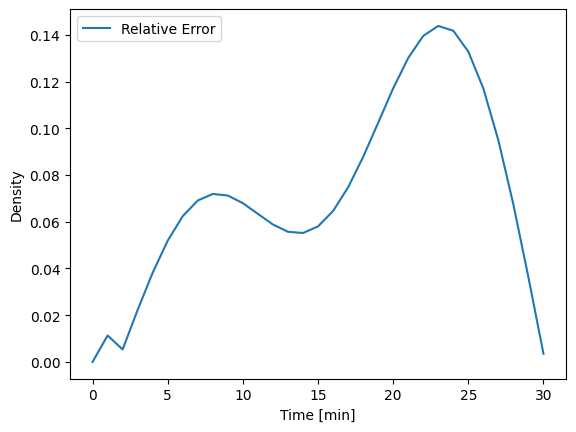

In [12]:
#plot relative error for density

columnToPlot = 6 #density

plt.ylabel("Density")
plt.plot(np.abs((deStandardizedData[:31][:, columnToPlot] - dataDense[:31][:, columnToPlot] )/ dataDense[:31][:, columnToPlot] ) , label='Relative Error')
plt.xlabel('Time [min]')
plt.legend()
plt.savefig('sindy-training-relativeError-' + str(columnToPlot) + '.pdf')  
plt.show()

In [20]:
from matplotlib import pyplot as plt
import numpy as np
import pathlib
import typing
import pandas as pd
import re

from ns_plots import orbitplot
from ns_plots import timeseries

#

timeseries.plot_series(
        x=[(timeDense/3600.0)[:31], (timeDense/3600.0)[:31]],
        y=[dataDense[:31][:, 6], deStandardizedData[:31][:, 6]],
        labels=["Predictions", "Labels"],
        xlabel="time [hour]",
        ylabel="density [kg/m^3]",
        title="Training data vs. model simulation (Density)",
        filepath = "Training data vs. model simulation (Density).pdf"
    )

# Plot comparing the mean errors with SINDy with the degree of the polynomial used (two lines for in-distribution and out-of-distribution), repeat the experiment 10 times and plot the mean and standard deviation of the error.

In [4]:
import time
from matplotlib import pyplot as plt
import numpy as np
import pathlib
import typing
import pandas as pd
import re
import pysindy as ps
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# Define the degrees of the polynomial library
polynomialDegrees = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

# Initialize arrays to store mean and standard deviation of errors
mean_errors = np.zeros(len(polynomialDegrees))
std_errors = np.zeros(len(polynomialDegrees))
training_times = np.zeros(len(polynomialDegrees))

# Repeat the experiment 10 times
num_repeats = 10
for repeat in range(num_repeats):
    errors_per_repeat = []
    times_per_repeat = []

    for i, poly_degree in enumerate(polynomialDegrees):
        polLib = ps.PolynomialLibrary(degree=poly_degree)

        standardizedXdotScaler1st = StandardScaler()
        standardizedXdot1st = standardizedXdotScaler1st.fit_transform(dataDense)

        optimizerKms = ps.FROLS(verbose=False)

        scalerData = StandardScaler()
        
        scaledOdeintData = scalerData.fit_transform(dataDense)

        scalerTime = StandardScaler()
        scaledTime = scalerTime.fit_transform(timeDense).flatten()

        model1stStandardized = ps.SINDy(
            feature_names=["posX", "posY", "posZ", "velX", "velY", "velZ", "density"],
            optimizer=optimizerKms,
            feature_library=polLib,
        )

        start_time = time.time()
        
        model1stStandardized.fit(scaledOdeintData, t=scaledTime, ensemble=True, quiet=True)
        
        end_time = time.time()
        training_time = end_time - start_time
        times_per_repeat.append(training_time)

        data1stSimulatedScaled = model1stStandardized.simulate(
            x0=scaledOdeintData[0], t=scaledTime, integrator="odeint"
        )
        deStandardizedData = scalerData.inverse_transform(data1stSimulatedScaled)

        # Calculate the errors and convert to km
        diff = scaledOdeintData - data1stSimulatedScaled
        errors = np.mean(np.abs(diff / 1000), axis=0)
        errors_per_repeat.append(errors)

    errors_per_repeat = np.array(errors_per_repeat)
    mean_errors += errors_per_repeat.mean(axis=0)
    std_errors += errors_per_repeat.std(axis=0)

mean_errors /= num_repeats
std_errors /= num_repeats
training_times /= num_repeats


# Plot the mean and standard deviation of errors with shading
plt.plot(polynomialDegrees, mean_errors, 'bo-', label="Mean Error")
plt.fill_between(polynomialDegrees, mean_errors - std_errors, mean_errors + std_errors, alpha=0.3, color='blue', label="Mean ± Std")

# Plot the training time
plt.plot(polynomialDegrees, training_times, 'ro--', label="Training Time")

plt.xlabel("Degree of Polynomial Library")
plt.ylabel("Mean Error (km) / Training Time (s)")
plt.title("SINDy Mean Error vs. Polynomial Degree")
plt.legend()
plt.grid(True)
plt.savefig("sindy_mean_error_and_training_time.pdf")
plt.show()

c:\Users\jpfun\Desktop\Gitlab Neuraspace\joao-funenga\venv\lib\site-packages\pysindy\pysindy.py:305: UserWarning: Ensembling arguments are deprecated.Use the EnsembleOptimizer class instead.
  warnings.warn(
c:\Users\jpfun\Desktop\Gitlab Neuraspace\joao-funenga\venv\lib\site-packages\pysindy\optimizers\base.py:289: UserWarning: n_models must be a positive integer.  Explicitly initialized to zero or None, defaulting to 20.
  warnings.warn(
c:\Users\jpfun\Desktop\Gitlab Neuraspace\joao-funenga\venv\lib\site-packages\pysindy\pysindy.py:305: UserWarning: Ensembling arguments are deprecated.Use the EnsembleOptimizer class instead.
  warnings.warn(
c:\Users\jpfun\Desktop\Gitlab Neuraspace\joao-funenga\venv\lib\site-packages\pysindy\optimizers\base.py:289: UserWarning: n_models must be a positive integer.  Explicitly initialized to zero or None, defaulting to 20.
  warnings.warn(
c:\Users\jpfun\Desktop\Gitlab Neuraspace\joao-funenga\venv\lib\site-packages\scipy\integrate\_odepack_py.py:248: O